# This is notebook implementing pipeline from the article

In [1]:
from data.generate_datasets import make_gravitational_waves
from pathlib import Path
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from gudhi.sklearn.rips_persistence import RipsPersistence
from gudhi.representations import DiagramSelector, Landscape

np.random.seed(42)

In [2]:
R = 0.305
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


In [3]:
# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise)))[:3500], y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background)))[:3500],
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal)))[:3500], y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()


In [4]:
time_series = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
time_series = np.array(time_series)
print(TimeDelayEmbedding(dim=2).fit(None).transform(time_series))

[array([[ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10]])]


In [5]:
class BatchPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.models_ = []

    def fit(self, X, y=None):
        self.models_ = []
        for cloud in X:
            model = PCA(n_components=self.n_components)
            model.fit(cloud)
            self.models_.append(model)
        return self

    def transform(self, X):
        return [model.transform(cloud) for model, cloud in zip(self.models_, X)]

In [13]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5
pipeline_embedder = Pipeline(
    [
        ("embedder", TimeDelayEmbedding(dim=embedding_dimension, delay=embedding_time_delay, skip=stride)),
        ("PCA", BatchPCA(n_components=3)),
    ]
)
embedded_clouds = pipeline_embedder.fit_transform(noisy_signals)[:1]


[array([[-1.46898535e-19, -1.26503169e-20, -3.17315106e-19],
       [ 1.69612009e-19, -2.21038183e-21,  3.78163825e-19],
       [-1.07450267e-19,  1.09483630e-21, -1.15636502e-19],
       ...,
       [-6.43867546e-19,  6.44270373e-20, -2.84895037e-19],
       [ 6.57062699e-19, -2.49110681e-19,  8.04191555e-19],
       [-4.82732505e-19,  3.65126489e-19, -5.34251992e-19]],
      shape=(8493, 3))]


In [14]:


pipeline_complex = Pipeline(
    [
        ("rips_pers", RipsPersistence(homology_dimensions=(0,1), n_jobs=-1, homology_coeff_field=2, num_collapses=0)),
        # ("finite_diags", DiagramSelector(use=True, point_type="finite")),
    ]
)

pers = pipeline_complex.fit_transform(embedded_clouds)

print(pers)

[[array([[0.00000000e+00, 1.12029377e-20],
       [0.00000000e+00, 1.45947059e-20],
       [0.00000000e+00, 1.54323177e-20],
       ...,
       [0.00000000e+00, 4.33592949e-19],
       [0.00000000e+00, 4.83690182e-19],
       [0.00000000e+00,            inf]], shape=(1565, 2)), array([[5.13363343e-19, 5.34762028e-19],
       [3.94037617e-19, 4.74091658e-19],
       [3.73698448e-19, 3.75508685e-19],
       ...,
       [5.56921387e-20, 6.19451540e-20],
       [5.42110984e-20, 5.63979966e-20],
       [4.17515428e-20, 4.39219892e-20]], shape=(833, 2))]]


# TO DO WIĘCEJ ŚMIESZNYCH CHMUR


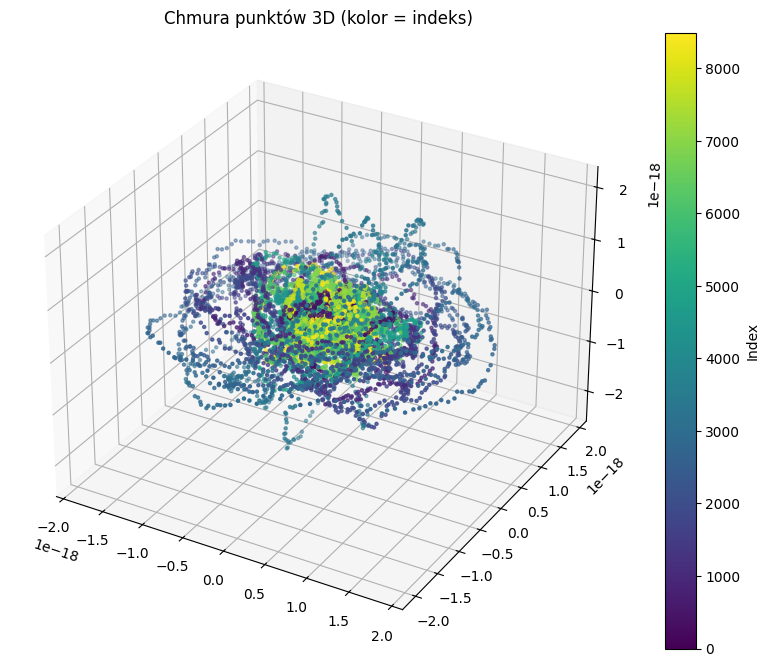

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Indeksy punktów jako kolory
points = embedded_clouds[signal_idx]
#points = embedded_clouds[background_idx]
indices = np.arange(points.shape[0])

# Rysowanie
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                c=indices, cmap='viridis', s=5)

plt.colorbar(sc, ax=ax, label='Index')
ax.set_title('Chmura punktów 3D (kolor = indeks)')
plt.show()